In [1]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

     |████████████████████████████████| 57 kB 3.6 MB/s 
     |████████████████████████████████| 208 kB 16.8 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 51 kB 8.7 MB/s 


2021-08-05 06:38:17.812 | WARNING  | torch_snippets.torch_loader:<module>:233 - Error: No module named 'pytorch_lightning'
Not importing Lightning Report
2021-08-05 06:38:18.405 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw




Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw




Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Deine the neural Network class : VAE

In [2]:
# define the layers in the __init__ method that wil be used in the other letter...

class VAE(nn.Module):
    def __init__(self,x_dim,h_dim1, h_dim2, z_dim):
        super(VAE,self).__init__()
        self.d1 = nn.Linear(x_dim,h_dim1) # d1 and d2 layers are the encoder
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim) #d31 and d32 layers are the mean and standard deviation
        self.d32 = nn.Linear(h_dim2 , z_dim) # d32 layer as a representation of the log of the variance..
        self.d4 = nn.Linear(z_dim ,h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1) #d5 and d6 layers are the decoder.
        self.d6 = nn.Linear(h_dim1,x_dim)
   
 # Define the encoder method..
    def encoder(self,x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h),self.d32(h)
# define the method to sample (sampling) from the encoder output..


    def sampling(self,mean,log_var):
        std =  torch.exp(0.5*log_var)# represents the standard deviation std
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    # define the decoder method

    def decoder(self,z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))

    # Define the forward method..

    def forward(self,x):
        mean,log_var = self.encoder(x.view(-1,784))
        z = self.sampling(mean,log_var)
        return self.decoder(z),mean,log_var

In [3]:
# define a function to train on a batch or validate on a batch...

def train_batch(data,model,optimizer,loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch,mean,log_var = model(data)
    loss,mse,kld = loss_function(recon_batch,data,mean,log_var)
    loss.backward()
    optimizer.step()
    return loss,mse,kld,log_var.mean(), mean.mean()


@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [4]:
# Define the loss function

def loss_function(recon_x,x,mean,log_var):
    RECON = F.mse_loss(recon_x, x.view(-1,784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD


In [5]:
# Define the model object (VAE) and the optimizer function

vae = VAE(x_dim=784 , h_dim1 = 512, h_dim2=256,\
          z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(),lr =1e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000	train_loss: 2949.255	train_kld: 248.889	train_recon: 2700.366	train_log_var: -0.149	train_mean: 0.001	val_loss: 2378.506	val_kld: 442.944	val_recon: 1935.562	val_log_var: -0.259	val_mean: 0.002	(9.42s - 84.82s remaining)


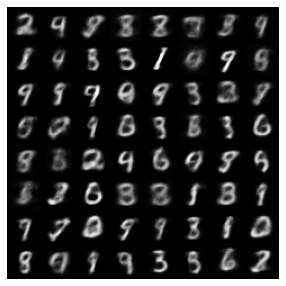

EPOCH: 2.000	train_loss: 2222.163	train_kld: 488.201	train_recon: 1733.962	train_log_var: -0.296	train_mean: 0.001	val_loss: 2090.319	val_kld: 508.059	val_recon: 1582.260	val_log_var: -0.310	val_mean: 0.003	(18.68s - 74.73s remaining)


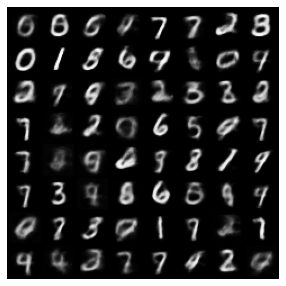

EPOCH: 3.000	train_loss: 2075.648	train_kld: 537.105	train_recon: 1538.543	train_log_var: -0.330	train_mean: 0.001	val_loss: 2022.025	val_kld: 558.602	val_recon: 1463.423	val_log_var: -0.338	val_mean: 0.004	(28.06s - 65.47s remaining)


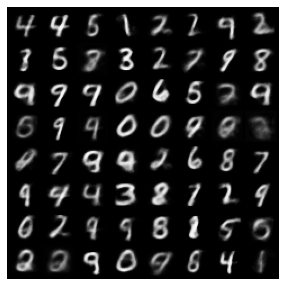

EPOCH: 4.000	train_loss: 2012.164	train_kld: 560.413	train_recon: 1451.751	train_log_var: -0.346	train_mean: 0.000	val_loss: 1960.665	val_kld: 566.607	val_recon: 1394.058	val_log_var: -0.348	val_mean: 0.002	(36.96s - 55.44s remaining)


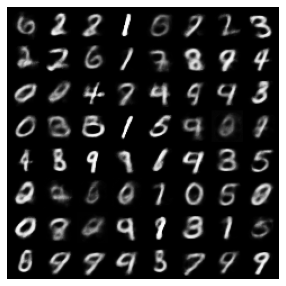

EPOCH: 5.000	train_loss: 1959.727	train_kld: 581.712	train_recon: 1378.015	train_log_var: -0.360	train_mean: 0.000	val_loss: 1930.729	val_kld: 591.096	val_recon: 1339.633	val_log_var: -0.368	val_mean: 0.005	(45.58s - 45.58s remaining)


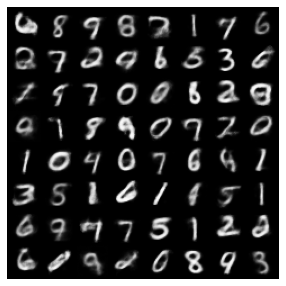

EPOCH: 6.000	train_loss: 1926.775	train_kld: 595.447	train_recon: 1331.328	train_log_var: -0.370	train_mean: -0.000	val_loss: 1900.184	val_kld: 602.629	val_recon: 1297.555	val_log_var: -0.375	val_mean: -0.001	(54.30s - 36.20s remaining)


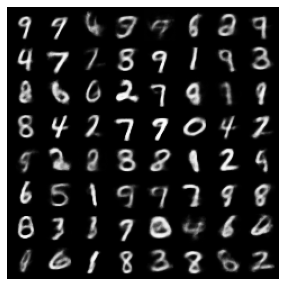

EPOCH: 7.000	train_loss: 1902.673	train_kld: 605.805	train_recon: 1296.868	train_log_var: -0.377	train_mean: -0.000	val_loss: 1883.657	val_kld: 609.870	val_recon: 1273.788	val_log_var: -0.377	val_mean: 0.005	(63.19s - 27.08s remaining)


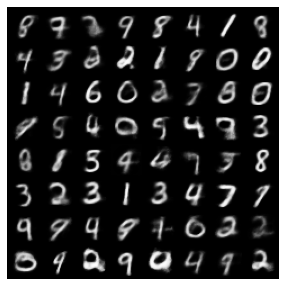

EPOCH: 8.000	train_loss: 1884.648	train_kld: 614.426	train_recon: 1270.222	train_log_var: -0.382	train_mean: -0.000	val_loss: 1865.179	val_kld: 618.451	val_recon: 1246.729	val_log_var: -0.388	val_mean: -0.002	(72.31s - 18.08s remaining)


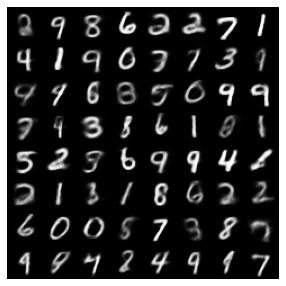

EPOCH: 9.000	train_loss: 1869.296	train_kld: 621.818	train_recon: 1247.478	train_log_var: -0.387	train_mean: 0.000	val_loss: 1850.009	val_kld: 610.167	val_recon: 1239.842	val_log_var: -0.380	val_mean: -0.005	(81.69s - 9.08s remaining)


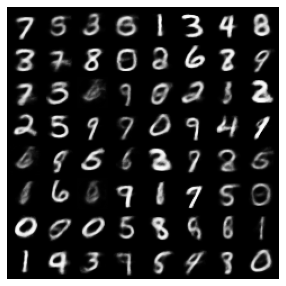

EPOCH: 10.000	train_loss: 1856.012	train_kld: 625.831	train_recon: 1230.181	train_log_var: -0.390	train_mean: 0.000	val_loss: 1848.874	val_kld: 607.635	val_recon: 1241.239	val_log_var: -0.382	val_mean: 0.000	(91.07s - 0.00s remaining)


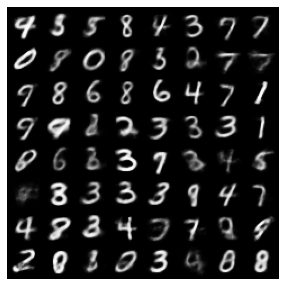

In [6]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0) # the make_grid function plot the images and denormalize them automatically, if required,before plotting
        show(images)

100%|██████████| 111/111 [00:00<00:00, 292.30it/s]


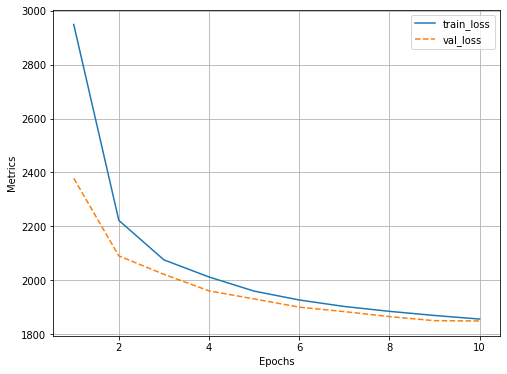

In [7]:
log.plot_epochs(['train_loss','val_loss'])